In [61]:
import pandas as pd
import re


file_path = 'evaluation/output.txt'  
with open(file_path, 'r') as file:
    lines = file.readlines()


data = []


current_run_name = None


for line in lines:
    line = line.strip()  
    if line: 
        if '|' not in line:  
            current_run_name = line
        else:  
            dataset_target = re.match(r'^(\w+-\w+):', line).group(1)
            dataset, target = dataset_target.split('-')

            accuracy_match = re.search(r'Accuracy:\s*([0-9.]+)', line)
            if accuracy_match:
                accuracy = float(accuracy_match.group(1))

            data.append({
                'run_name': current_run_name,
                'dataset': dataset,
                'target': target,
                'accuracy': accuracy
            })

df = pd.DataFrame(data)

print(df)


                      run_name   dataset     target  accuracy
0      CLIP-ViT-B-16-continent      k78k  continent    0.9097
1      CLIP-ViT-B-16-continent      k78k    country    0.5019
2      CLIP-ViT-B-16-continent    im2gps  continent    0.7215
3      CLIP-ViT-B-16-continent    im2gps    country    0.5021
4      CLIP-ViT-B-16-continent  im2gps2k  continent    0.6105
..                         ...       ...        ...       ...
155  ViT-B-16-country-finetune  im2gps2k    country    0.1205
156  ViT-B-16-country-finetune  im2gps3k  continent    0.0000
157  ViT-B-16-country-finetune  im2gps3k    country    0.1158
158  ViT-B-16-country-finetune    yfcc4k  continent    0.0000
159  ViT-B-16-country-finetune    yfcc4k    country    0.1254

[160 rows x 4 columns]


In [62]:
from datasets import load_dataset


ds_k78k = load_dataset("jrheiner/geo_training_v3", split="test")
ds_im2gps = load_dataset("jrheiner/im2gps", split="train")
ds_im2gps2k = load_dataset("jrheiner/im2gps2k", split="train")
ds_im2gps3k = load_dataset("jrheiner/im2gps3k", split="train")
ds_yfcc4k = load_dataset("jrheiner/yfcc4k", split="train")

def map_id2label(example):
    example["country_str"] = ds_im2gps.features["country"].int2str(example["country"])
    example["continent_str"] = ds_im2gps.features["continent"].int2str(example["continent"])
    return example

ds_im2gps = ds_im2gps.map(map_id2label, batched=True)
ds_im2gps = ds_im2gps.remove_columns(["country", "continent"])
ds_im2gps = ds_im2gps.rename_column("country_str", "country")
ds_im2gps = ds_im2gps.rename_column("continent_str", "continent")

def map_id2label(example):
    example["country_str"] = ds_im2gps2k.features["country"].int2str(example["country"])
    example["continent_str"] = ds_im2gps2k.features["continent"].int2str(example["continent"])
    return example

ds_im2gps2k = ds_im2gps2k.map(map_id2label, batched=True)
ds_im2gps2k = ds_im2gps2k.remove_columns(["country", "continent"])
ds_im2gps2k = ds_im2gps2k.rename_column("country_str", "country")
ds_im2gps2k = ds_im2gps2k.rename_column("continent_str", "continent")

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

In [63]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import f1_score, recall_score, precision_score

datasets_map = {
    'k78k': ds_k78k,
    'im2gps': ds_im2gps,
    'im2gps2k': ds_im2gps2k,
    'im2gps3k': ds_im2gps3k,
    'yfcc4k': ds_yfcc4k,
}

df['f1_score'] = np.nan
df['recall'] = np.nan
df['precision'] = np.nan

for index, row in df.iterrows():
    run_name = row['run_name']
    dataset = row['dataset']
    target = row['target']

    file_name = f"{dataset}-{target}.npy"
    file_path = os.path.join("evals", run_name, file_name)

    if os.path.exists(file_path):
        predicted_labels = np.load(file_path)

        if dataset in datasets_map:
            true_labels = datasets_map[dataset][target]

            f1 = f1_score(true_labels, predicted_labels, average='macro')
            recall = recall_score(true_labels, predicted_labels, average='macro')
            precision = precision_score(true_labels, predicted_labels, average='macro')

            df.at[index, 'f1_score'] = f1
            df.at[index, 'recall'] = recall
            df.at[index, 'precision'] = precision

print(df)

/home/s1/projects/mthesis-code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s1/projects/mthesis-code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s1/projects/mthesis-code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

                      run_name   dataset     target  accuracy  f1_score  \
0      CLIP-ViT-B-16-continent      k78k  continent    0.9097  0.909699   
1      CLIP-ViT-B-16-continent      k78k    country    0.5019  0.131520   
2      CLIP-ViT-B-16-continent    im2gps  continent    0.7215  0.633888   
3      CLIP-ViT-B-16-continent    im2gps    country    0.5021  0.348182   
4      CLIP-ViT-B-16-continent  im2gps2k  continent    0.6105  0.501744   
..                         ...       ...        ...       ...       ...   
155  ViT-B-16-country-finetune  im2gps2k    country    0.1205  0.014169   
156  ViT-B-16-country-finetune  im2gps3k  continent    0.0000  0.000000   
157  ViT-B-16-country-finetune  im2gps3k    country    0.1158  0.018169   
158  ViT-B-16-country-finetune    yfcc4k  continent    0.0000  0.000000   
159  ViT-B-16-country-finetune    yfcc4k    country    0.1254  0.014748   

       recall  precision  
0    0.909687   0.910083  
1    0.170293   0.193838  
2    0.686701   0.

/home/s1/projects/mthesis-code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s1/projects/mthesis-code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s1/projects/mthesis-code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

In [64]:
df.to_csv("evaluation/benchmark_results.csv", index=False)

In [65]:
print(df)

                      run_name   dataset     target  accuracy  f1_score  \
0      CLIP-ViT-B-16-continent      k78k  continent    0.9097  0.909699   
1      CLIP-ViT-B-16-continent      k78k    country    0.5019  0.131520   
2      CLIP-ViT-B-16-continent    im2gps  continent    0.7215  0.633888   
3      CLIP-ViT-B-16-continent    im2gps    country    0.5021  0.348182   
4      CLIP-ViT-B-16-continent  im2gps2k  continent    0.6105  0.501744   
..                         ...       ...        ...       ...       ...   
155  ViT-B-16-country-finetune  im2gps2k    country    0.1205  0.014169   
156  ViT-B-16-country-finetune  im2gps3k  continent    0.0000  0.000000   
157  ViT-B-16-country-finetune  im2gps3k    country    0.1158  0.018169   
158  ViT-B-16-country-finetune    yfcc4k  continent    0.0000  0.000000   
159  ViT-B-16-country-finetune    yfcc4k    country    0.1254  0.014748   

       recall  precision  
0    0.909687   0.910083  
1    0.170293   0.193838  
2    0.686701   0.

In [66]:
grouped_stats = df.groupby(['run_name', 'target']).agg({
    'accuracy': ['mean', 'std'],
    'f1_score': ['mean', 'std'],
    'recall': ['mean', 'std'],
    'precision': ['mean', 'std']
}).reset_index()

grouped_stats


run_name     target accuracy            \
                                                          mean       std   
0             CLIP-ViT-B-16-combinedlabels  continent  0.66464  0.096639   
1             CLIP-ViT-B-16-combinedlabels    country  0.46108  0.159998   
2       CLIP-ViT-B-16-combinedlabels-osv5m  continent  0.65418  0.093280   
3       CLIP-ViT-B-16-combinedlabels-osv5m    country  0.45752  0.181647   
4                  CLIP-ViT-B-16-continent  continent  0.70226  0.124346   
5                  CLIP-ViT-B-16-continent    country  0.38946  0.105668   
6            CLIP-ViT-B-16-continent-osv5m  continent  0.71394  0.126358   
7            CLIP-ViT-B-16-continent-osv5m    country  0.39682  0.092522   
8         CLIP-ViT-B-16-continent-zeroshot  continent  0.56246  0.109944   
9         CLIP-ViT-B-16-continent-zeroshot    country  0.44292  0.109391   
10        CLIP-ViT-L-14-336-combinedlabels  continent  0.77844  0.118339   
11        CLIP-ViT-L-14-336-combinedlabels    country  0.62390  0.136805   
12  CLIP-ViT-L-14-336-combinedlabels-osv5m  continent  0.79198  0.096501   
13  CLIP-ViT-L-14-336-combinedlabels-osv5m    country  0.61482  0.141494   
14             CLIP-ViT-L-14-336-continent  continent  0.80234  0.102897   
15             CLIP-ViT-L-14-336-continent    country  0.53672  0.110642   
16       CLIP-ViT-L-14-336-continent-osv5m  continent  0.82560  0.099423   
17       CLIP-ViT-L-14-336-continent-osv5m    country  0.57046  0.107170   
18    CLIP-ViT-L-14-336-continent-zeroshot  continent  0.68186  0.100886   
19    CLIP-ViT-L-14-336-continent-zeroshot    country  0.51906  0.125551   
20             ViT-B-16-continent-finetune  continent  0.46494  0.220504   
21             ViT-B-16-continent-finetune    country  0.00000  0.000000   
22               ViT-B-16-country-finetune  continent  0.00000  0.000000   
23               ViT-B-16-country-finetune    country  0.24666  0.278613   
24             ViT-T-16-continent-finetune  continent  0.36484  0.243370   
25             ViT-T-16-continent-finetune    country  0.00000  0.000000   
26              ViT-T-16-continent-scratch  continent  0.28674  0.161880   
27              ViT-T-16-continent-scratch    country  0.00000  0.000000   
28               ViT-T-16-country-finetune  continent  0.00000  0.000000   
29               ViT-T-16-country-finetune    country  0.18594  0.274986   
30                ViT-T-16-country-scratch  continent  0.00000  0.000000   
31                ViT-T-16-country-scratch    country  0.13698  0.184020   

    f1_score              recall           precision            
        mean       std      mean       std      mean       std  
0   0.566253  0.154504  0.638055  0.125209  0.590514  0.152266  
1   0.245328  0.116955  0.336438  0.123384  0.250814  0.115314  
2   0.560791  0.146011  0.634479  0.128817  0.590256  0.149698  
3   0.262359  0.144733  0.352960  0.141850  0.274936  0.139146  
4   0.596358  0.191361  0.632977  0.177471  0.591412  0.192253  
5   0.175293  0.099330  0.245455  0.105584  0.193261  0.085244  
6   0.613246  0.197728  0.655729  0.177809  0.602414  0.199801  
7   0.129150  0.068298  0.176301  0.074111  0.146060  0.072230  
8   0.501833  0.126587  0.576829  0.113163  0.563479  0.104786  
9   0.222742  0.114844  0.332818  0.121624  0.258189  0.097619  
10  0.708588  0.147180  0.766329  0.131679  0.712422  0.131798  
11  0.376879  0.137763  0.486535  0.128356  0.374355  0.135200  
12  0.701595  0.137145  0.739188  0.139597  0.712861  0.124196  
13  0.365809  0.133817  0.470443  0.119267  0.364780  0.135107  
14  0.707472  0.164647  0.758064  0.142963  0.709783  0.161679  
15  0.311370  0.113500  0.424896  0.102529  0.323141  0.111009  
16  0.736535  0.166363  0.774349  0.150759  0.733272  0.160206  
17  0.315751  0.110264  0.423051  0.101280  0.324551  0.109215  
18  0.600526  0.133037  0.676381  0.123204  0.637217  0.122761  
19  0.341996  0.136720  0.465783  0.124509  0.355889  0.129227  
20  0.384591  0.265

In [67]:
grouped_stats.sort_values(('accuracy', 'mean'), ascending=False)

run_name     target accuracy            \
                                                          mean       std   
16       CLIP-ViT-L-14-336-continent-osv5m  continent  0.82560  0.099423   
14             CLIP-ViT-L-14-336-continent  continent  0.80234  0.102897   
12  CLIP-ViT-L-14-336-combinedlabels-osv5m  continent  0.79198  0.096501   
10        CLIP-ViT-L-14-336-combinedlabels  continent  0.77844  0.118339   
6            CLIP-ViT-B-16-continent-osv5m  continent  0.71394  0.126358   
4                  CLIP-ViT-B-16-continent  continent  0.70226  0.124346   
18    CLIP-ViT-L-14-336-continent-zeroshot  continent  0.68186  0.100886   
0             CLIP-ViT-B-16-combinedlabels  continent  0.66464  0.096639   
2       CLIP-ViT-B-16-combinedlabels-osv5m  continent  0.65418  0.093280   
11        CLIP-ViT-L-14-336-combinedlabels    country  0.62390  0.136805   
13  CLIP-ViT-L-14-336-combinedlabels-osv5m    country  0.61482  0.141494   
17       CLIP-ViT-L-14-336-continent-osv5m    country  0.57046  0.107170   
8         CLIP-ViT-B-16-continent-zeroshot  continent  0.56246  0.109944   
15             CLIP-ViT-L-14-336-continent    country  0.53672  0.110642   
19    CLIP-ViT-L-14-336-continent-zeroshot    country  0.51906  0.125551   
20             ViT-B-16-continent-finetune  continent  0.46494  0.220504   
1             CLIP-ViT-B-16-combinedlabels    country  0.46108  0.159998   
3       CLIP-ViT-B-16-combinedlabels-osv5m    country  0.45752  0.181647   
9         CLIP-ViT-B-16-continent-zeroshot    country  0.44292  0.109391   
7            CLIP-ViT-B-16-continent-osv5m    country  0.39682  0.092522   
5                  CLIP-ViT-B-16-continent    country  0.38946  0.105668   
24             ViT-T-16-continent-finetune  continent  0.36484  0.243370   
26              ViT-T-16-continent-scratch  continent  0.28674  0.161880   
23               ViT-B-16-country-finetune    country  0.24666  0.278613   
29               ViT-T-16-country-finetune    country  0.18594  0.274986   
31                ViT-T-16-country-scratch    country  0.13698  0.184020   
22               ViT-B-16-country-finetune  continent  0.00000  0.000000   
21             ViT-B-16-continent-finetune    country  0.00000  0.000000   
27              ViT-T-16-continent-scratch    country  0.00000  0.000000   
25             ViT-T-16-continent-finetune    country  0.00000  0.000000   
28               ViT-T-16-country-finetune  continent  0.00000  0.000000   
30                ViT-T-16-country-scratch  continent  0.00000  0.000000   

    f1_score              recall           precision            
        mean       std      mean       std      mean       std  
16  0.736535  0.166363  0.774349  0.150759  0.733272  0.160206  
14  0.707472  0.164647  0.758064  0.142963  0.709783  0.161679  
12  0.701595  0.137145  0.739188  0.139597  0.712861  0.124196  
10  0.708588  0.147180  0.766329  0.131679  0.712422  0.131798  
6   0.613246  0.197728  0.655729  0.177809  0.602414  0.199801  
4   0.596358  0.191361  0.632977  0.177471  0.591412  0.192253  
18  0.600526  0.133037  0.676381  0.123204  0.637217  0.122761  
0   0.566253  0.154504  0.638055  0.125209  0.590514  0.152266  
2   0.560791  0.146011  0.634479  0.128817  0.590256  0.149698  
11  0.376879  0.137763  0.486535  0.128356  0.374355  0.135200  
13  0.365809  0.133817  0.470443  0.119267  0.364780  0.135107  
17  0.315751  0.110264  0.423051  0.101280  0.324551  0.109215  
8   0.501833  0.126587  0.576829  0.113163  0.563479  0.104786  
15  0.311370  0.113500  0.424896  0.102529  0.323141  0.111009  
19  0.341996  0.136720  0.465783  0.124509  0.355889  0.129227  
20  0.384591  0.265903  0.421031  0.244445  0.419047  0.246266  
1   0.245328  0.116955  0.336438  0.123384  0.250814  0.115314  
3   0.262359  0.144733  0.352960  0.141850  0.274936  0.139146  
9   0.222742  0.114844  0.332818  0.121624  0.258189  0.097619  
7   0.129150  0.068298  0.176301  0.074111  0.146060  0.072230  
5   0.175293  0.099

In [68]:
df

run_name   dataset     target  accuracy  f1_score  \
0      CLIP-ViT-B-16-continent      k78k  continent    0.9097  0.909699   
1      CLIP-ViT-B-16-continent      k78k    country    0.5019  0.131520   
2      CLIP-ViT-B-16-continent    im2gps  continent    0.7215  0.633888   
3      CLIP-ViT-B-16-continent    im2gps    country    0.5021  0.348182   
4      CLIP-ViT-B-16-continent  im2gps2k  continent    0.6105  0.501744   
..                         ...       ...        ...       ...       ...   
155  ViT-B-16-country-finetune  im2gps2k    country    0.1205  0.014169   
156  ViT-B-16-country-finetune  im2gps3k  continent    0.0000  0.000000   
157  ViT-B-16-country-finetune  im2gps3k    country    0.1158  0.018169   
158  ViT-B-16-country-finetune    yfcc4k  continent    0.0000  0.000000   
159  ViT-B-16-country-finetune    yfcc4k    country    0.1254  0.014748   

       recall  precision  
0    0.909687   0.910083  
1    0.170293   0.193838  
2    0.686701   0.615904  
3    0.421770   0.333360  
4    0.524277   0.509824  
..        ...        ...  
155  0.021832   0.017770  
156  0.000000   0.000000  
157  0.027352   0.025227  
158  0.000000   0.000000  
159  0.018892   0.022254  

[160 rows x 7 columns]

In [69]:
print(df.to_string())

                                   run_name   dataset     target  accuracy  f1_score    recall  precision
0                   CLIP-ViT-B-16-continent      k78k  continent    0.9097  0.909699  0.909687   0.910083
1                   CLIP-ViT-B-16-continent      k78k    country    0.5019  0.131520  0.170293   0.193838
2                   CLIP-ViT-B-16-continent    im2gps  continent    0.7215  0.633888  0.686701   0.615904
3                   CLIP-ViT-B-16-continent    im2gps    country    0.5021  0.348182  0.421770   0.333360
4                   CLIP-ViT-B-16-continent  im2gps2k  continent    0.6105  0.501744  0.524277   0.509824
5                   CLIP-ViT-B-16-continent  im2gps2k    country    0.3055  0.117312  0.179646   0.129894
6                   CLIP-ViT-B-16-continent  im2gps3k  continent    0.6563  0.518734  0.593281   0.509743
7                   CLIP-ViT-B-16-continent  im2gps3k    country    0.3530  0.169455  0.265867   0.189492
8                   CLIP-ViT-B-16-continent   

In [70]:
df[df["dataset"] == "yfcc4k"].sort_values("accuracy", ascending=False) 

run_name dataset     target  accuracy  \
78        CLIP-ViT-L-14-336-continent-osv5m  yfcc4k  continent    0.7189   
58              CLIP-ViT-L-14-336-continent  yfcc4k  continent    0.6825   
88   CLIP-ViT-L-14-336-combinedlabels-osv5m  yfcc4k  continent    0.6510   
8                   CLIP-ViT-B-16-continent  yfcc4k  continent    0.6133   
28            CLIP-ViT-B-16-continent-osv5m  yfcc4k  continent    0.6080   
68         CLIP-ViT-L-14-336-combinedlabels  yfcc4k  continent    0.6049   
18             CLIP-ViT-B-16-combinedlabels  yfcc4k  continent    0.5763   
38       CLIP-ViT-B-16-combinedlabels-osv5m  yfcc4k  continent    0.5578   
98     CLIP-ViT-L-14-336-continent-zeroshot  yfcc4k  continent    0.5331   
69         CLIP-ViT-L-14-336-combinedlabels  yfcc4k    country    0.4888   
89   CLIP-ViT-L-14-336-combinedlabels-osv5m  yfcc4k    country    0.4755   
79        CLIP-ViT-L-14-336-continent-osv5m  yfcc4k    country    0.4563   
59              CLIP-ViT-L-14-336-continent  yfcc4k    country    0.4231   
48         CLIP-ViT-B-16-continent-zeroshot  yfcc4k  continent    0.4147   
99     CLIP-ViT-L-14-336-continent-zeroshot  yfcc4k    country    0.3836   
49         CLIP-ViT-B-16-continent-zeroshot  yfcc4k    country    0.3810   
19             CLIP-ViT-B-16-combinedlabels  yfcc4k    country    0.3234   
29            CLIP-ViT-B-16-continent-osv5m  yfcc4k    country    0.3228   
148             ViT-B-16-continent-finetune  yfcc4k  continent    0.3104   
39       CLIP-ViT-B-16-combinedlabels-osv5m  yfcc4k    country    0.3020   
9                   CLIP-ViT-B-16-continent  yfcc4k    country    0.2848   
128             ViT-T-16-continent-finetune  yfcc4k  continent    0.2240   
108              ViT-T-16-continent-scratch  yfcc4k  continent    0.1825   
159               ViT-B-16-country-finetune  yfcc4k    country    0.1254   
119                ViT-T-16-country-scratch  yfcc4k    country    0.0657   
139               ViT-T-16-country-finetune  yfcc4k    country    0.0626   
118                ViT-T-16-country-scratch  yfcc4k  continent    0.0000   
109              ViT-T-16-continent-scratch  yfcc4k    country    0.0000   
138               ViT-T-16-country-finetune  yfcc4k  continent    0.0000   
129             ViT-T-16-continent-finetune  yfcc4k    country    0.0000   
149             ViT-B-16-continent-finetune  yfcc4k    country    0.0000   
158               ViT-B-16-country-finetune  yfcc4k  continent    0.0000   

     f1_score    recall  precision  
78   0.532509  0.581752   0.539347  
58   0.506117  0.566657   0.511183  
88   0.532332  0.535064   0.571154  
8    0.417728  0.450938   0.411503  
28   0.406446  0.460194   0.400377  
68   0.524581  0.582254   0.573867  
18   0.400269  0.483669   0.405679  
38   0.401075  0.468724   0.417413  
98   0.430424  0.481244   0.482403  
69   0.278068  0.423880   0.267835  
89   0.258216  0.392227   0.251933  
79   0.224932  0.372467   0.217002  
59   0.217377  0.371451   0.216645  
48   0.340317  0.403018   0.421620  
99   0.245630  0.396939   0.249468  
49   0.145676  0.261693   0.183624  
19   0.137998  0.245427   0.137934  
29   0.096275  0.165658   0.095413  
148  0.189665  0.251965   0.239600  
39   0.133222  0.245552   0.150716  
9    0.109999  0.189701   0.119719  
128  0.136216  0.206254   0.183019  
108  0.114912  0.168574   0.154823  
159  0.014748  0.018892   0.022254  
119  0.003084  0.006209   0.005268  
139  0.004870  0.008787   0.008134  
118  0.000000  0.000000   0.000000  
109  0.000000  0.000000   0.000000  
138  0.000000  0.000000   0.000000  
129  0.000000  0.000000   0.000000  
149  0.000000  0.000000   0.000000  
158  0.000000  0.000000   0.000000

In [71]:
k78k_df = df[df["dataset"] == "k78k"]#.sort_values("accuracy", ascending=False) 
k78k_df = k78k_df[k78k_df["run_name"].str.startswith("CLIP")]
k78k_df

run_name dataset     target  accuracy  \
0                  CLIP-ViT-B-16-continent    k78k  continent    0.9097   
1                  CLIP-ViT-B-16-continent    k78k    country    0.5019   
10            CLIP-ViT-B-16-combinedlabels    k78k  continent    0.8058   
11            CLIP-ViT-B-16-combinedlabels    k78k    country    0.6835   
20           CLIP-ViT-B-16-continent-osv5m    k78k  continent    0.9184   
21           CLIP-ViT-B-16-continent-osv5m    k78k    country    0.5308   
30      CLIP-ViT-B-16-combinedlabels-osv5m    k78k  continent    0.7936   
31      CLIP-ViT-B-16-combinedlabels-osv5m    k78k    country    0.7288   
40        CLIP-ViT-B-16-continent-zeroshot    k78k  continent    0.6893   
41        CLIP-ViT-B-16-continent-zeroshot    k78k    country    0.3756   
50             CLIP-ViT-L-14-336-continent    k78k  continent    0.9426   
51             CLIP-ViT-L-14-336-continent    k78k    country    0.6346   
60        CLIP-ViT-L-14-336-combinedlabels    k78k  continent    0.9100   
61        CLIP-ViT-L-14-336-combinedlabels    k78k    country    0.7942   
70       CLIP-ViT-L-14-336-continent-osv5m    k78k  continent    0.9536   
71       CLIP-ViT-L-14-336-continent-osv5m    k78k    country    0.6671   
80  CLIP-ViT-L-14-336-combinedlabels-osv5m    k78k  continent    0.8899   
81  CLIP-ViT-L-14-336-combinedlabels-osv5m    k78k    country    0.8051   
90    CLIP-ViT-L-14-336-continent-zeroshot    k78k  continent    0.7959   
91    CLIP-ViT-L-14-336-continent-zeroshot    k78k    country    0.5604   

    f1_score    recall  precision  
0   0.909699  0.909687   0.910083  
1   0.131520  0.170293   0.193838  
10  0.800403  0.805840   0.811663  
11  0.376996  0.482426   0.385717  
20  0.918236  0.918376   0.918398  
21  0.113594  0.145669   0.146782  
30  0.781850  0.793590   0.814444  
31  0.430071  0.528967   0.428253  
40  0.673560  0.689316   0.702038  
41  0.166216  0.248898   0.221682  
50  0.942741  0.942593   0.943933  
51  0.295698  0.365810   0.346142  
60  0.909647  0.909972   0.912397  
61  0.473200  0.563981   0.476776  
70  0.953712  0.953561   0.954496  
71  0.294343  0.364492   0.348439  
80  0.888135  0.889886   0.897640  
81  0.496708  0.585406   0.504801  
90  0.782737  0.795869   0.812009  
91  0.297239  0.385693   0.348762

In [72]:
k78k_df[k78k_df["target"] == "country"]["accuracy"]

1     0.5019
11    0.6835
21    0.5308
31    0.7288
41    0.3756
51    0.6346
61    0.7942
71    0.6671
81    0.8051
91    0.5604
Name: accuracy, dtype: float64

In [73]:
k78k_df["run_name"]

0                    CLIP-ViT-B-16-continent
1                    CLIP-ViT-B-16-continent
10              CLIP-ViT-B-16-combinedlabels
11              CLIP-ViT-B-16-combinedlabels
20             CLIP-ViT-B-16-continent-osv5m
21             CLIP-ViT-B-16-continent-osv5m
30        CLIP-ViT-B-16-combinedlabels-osv5m
31        CLIP-ViT-B-16-combinedlabels-osv5m
40          CLIP-ViT-B-16-continent-zeroshot
41          CLIP-ViT-B-16-continent-zeroshot
50               CLIP-ViT-L-14-336-continent
51               CLIP-ViT-L-14-336-continent
60          CLIP-ViT-L-14-336-combinedlabels
61          CLIP-ViT-L-14-336-combinedlabels
70         CLIP-ViT-L-14-336-continent-osv5m
71         CLIP-ViT-L-14-336-continent-osv5m
80    CLIP-ViT-L-14-336-combinedlabels-osv5m
81    CLIP-ViT-L-14-336-combinedlabels-osv5m
90      CLIP-ViT-L-14-336-continent-zeroshot
91      CLIP-ViT-L-14-336-continent-zeroshot
Name: run_name, dtype: object

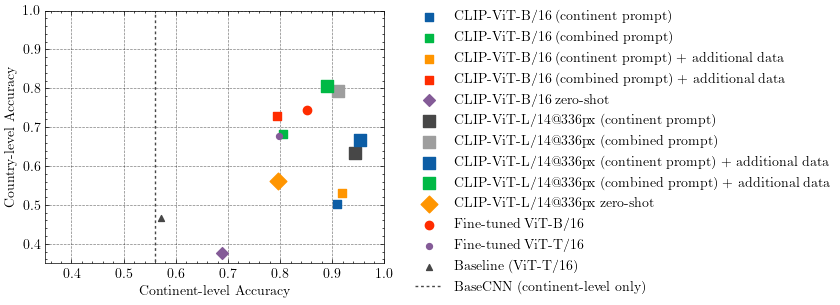

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

import scienceplots

plt.style.use(['science', 'std-colors', 'grid'])
plt.rcParams["axes.axisbelow"] = True
plt.rcParams['figure.figsize'] = (3.5*1.25, 2.625*1.25)

k78k_df = df[df["dataset"] == "k78k"] 
k78k_df = k78k_df[k78k_df["run_name"].str.startswith("CLIP")]

additional_results= {
    "Fine-tuned ViT-B/16": {
        "continent": df.query("run_name == 'ViT-B-16-continent-finetune' & target=='continent' & dataset == 'k78k'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-B-16-country-finetune' & target=='country' & dataset == 'k78k'")["accuracy"].item()
    },
    "Fine-tuned ViT-T/16": {
        "continent": df.query("run_name == 'ViT-T-16-continent-finetune' & target=='continent' & dataset == 'k78k'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-T-16-country-finetune' & target=='country' & dataset == 'k78k'")["accuracy"].item()
    },
    "Baseline (ViT-T/16)": {
        "continent": df.query("run_name == 'ViT-T-16-continent-scratch' & target=='continent' & dataset == 'k78k'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-T-16-country-scratch' & target=='country' & dataset == 'k78k'")["accuracy"].item()
    },
}


continent_accuracy = k78k_df[k78k_df["target"] == "continent"]["accuracy"].values.tolist()
country_accuracy = k78k_df[k78k_df["target"] == "country"]["accuracy"].values.tolist()
run_names = k78k_df[k78k_df["target"] == "continent"]["run_name"].values.tolist()

run_names.extend(additional_results.keys())
continent_accuracy.extend([result["continent"] for result in additional_results.values()])
country_accuracy.extend([result["country"] for result in additional_results.values()])

model_sizes = []
for run in run_names:
    if "ViT-T" in run:
        model_sizes.append("tiny")
    elif "ViT-B" in run:
        model_sizes.append("base")
    elif "ViT-L" in run:
        model_sizes.append("large")
    else:
        model_sizes.append("undefined")

marker_class = []
for run in run_names:
    if "zeroshot" in run:
        marker_class.append("zeroshot")
    elif "CLIP" in run:
        marker_class.append("clip")
    elif "Baseline" in run:
        marker_class.append("scratch")
    elif "ViT" in run:
        marker_class.append("vit-only")
    else:
        model_sizes.append("undefined")

marker_map = {"clip": "s", "zeroshot": "D", "vit-only": "o", "scratch": "^", "undefined": "x"}
# color_map = {"clip": "#0C5DA5", "zeroshot": "#00B945", "vit-only": "#FF9500","scratch": "#FF2C00", "undefined": "red"}

size_map = {
    "tiny": 36/2,
    "base": 36,
    "large": 36*2,
    "undefined": 200
}

run_names = [r.replace("CLIP-ViT-B-16", "CLIP-ViT-B/16").replace("CLIP-ViT-L-14", "CLIP-ViT-L/14").replace("-336", "@336px").replace("-combinedlabels", " (combined prompt)").replace("-continent-zeroshot", " zero-shot").replace("-continent", " (continent prompt)").replace("-osv5m", " + additional data") for r in run_names]


for continent_acc, country_acc, run, size, mclass in zip(continent_accuracy, country_accuracy, run_names, model_sizes, marker_class):
    plt.scatter(continent_acc, country_acc, marker=marker_map[mclass], s=size_map[size], label=f"{run}", alpha=1)


plt.vlines(0.5603, 0, 1, colors='#474747', linestyles=(0, (2,2)), label='BaseCNN (continent-level only)')

plt.legend(loc="upper right", bbox_to_anchor=(2.35, 1.05), frameon=False)
plt.xlabel("Continent-level Accuracy")
plt.ylabel("Country-level Accuracy")
plt.xlim(0.35, 1)
plt.ylim(0.35, 1)
plt.savefig("figures/k78k-testset-accuracy-overview-plot.png",bbox_inches='tight', dpi=600)
plt.savefig("figures/k78k-testset-accuracy-overview-plot.pdf",bbox_inches='tight', dpi=600)
plt.show()

In [75]:
for continent, country, run in zip(continent_accuracy, country_accuracy, run_names):
    print(continent, country, run)

0.9097 0.5019 CLIP-ViT-B/16 (continent prompt)
0.8058 0.6835 CLIP-ViT-B/16 (combined prompt)
0.9184 0.5308 CLIP-ViT-B/16 (continent prompt) + additional data
0.7936 0.7288 CLIP-ViT-B/16 (combined prompt) + additional data
0.6893 0.3756 CLIP-ViT-B/16 zero-shot
0.9426 0.6346 CLIP-ViT-L/14@336px (continent prompt)
0.91 0.7942 CLIP-ViT-L/14@336px (combined prompt)
0.9536 0.6671 CLIP-ViT-L/14@336px (continent prompt) + additional data
0.8899 0.8051 CLIP-ViT-L/14@336px (combined prompt) + additional data
0.7959 0.5604 CLIP-ViT-L/14@336px zero-shot
0.8507 0.745 Fine-tuned ViT-B/16
0.7976 0.6775 Fine-tuned ViT-T/16
0.5721 0.4652 Baseline (ViT-T/16)


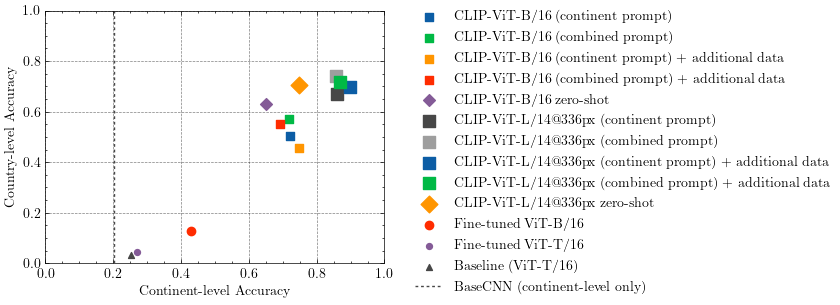

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

import scienceplots

plt.style.use(["science", "std-colors",])
plt.rcParams["axes.axisbelow"] = True
plt.rcParams['figure.figsize'] = (3.5*1.25, 2.625*1.25)

im2gps_df = df[df["dataset"] == "im2gps"] 
im2gps_df = im2gps_df[im2gps_df["run_name"].str.startswith("CLIP")]

additional_results= {
    "Fine-tuned ViT-B/16": {
        "continent": df.query("run_name == 'ViT-B-16-continent-finetune' & target=='continent' & dataset == 'im2gps'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-B-16-country-finetune' & target=='country' & dataset == 'im2gps'")["accuracy"].item()
    },
    "Fine-tuned ViT-T/16": {
        "continent": df.query("run_name == 'ViT-T-16-continent-finetune' & target=='continent' & dataset == 'im2gps'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-T-16-country-finetune' & target=='country' & dataset == 'im2gps'")["accuracy"].item()
    },
    "Baseline (ViT-T/16)": {
        "continent": df.query("run_name == 'ViT-T-16-continent-scratch' & target=='continent' & dataset == 'im2gps'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-T-16-country-scratch' & target=='country' & dataset == 'im2gps'")["accuracy"].item()
    },
}


continent_accuracy = im2gps_df[im2gps_df["target"] == "continent"]["accuracy"].values.tolist()
country_accuracy = im2gps_df[im2gps_df["target"] == "country"]["accuracy"].values.tolist()
run_names = im2gps_df[im2gps_df["target"] == "continent"]["run_name"].values.tolist()

run_names.extend(additional_results.keys())
continent_accuracy.extend([result["continent"] for result in additional_results.values()])
country_accuracy.extend([result["country"] for result in additional_results.values()])

model_sizes = []
for run in run_names:
    if "ViT-T" in run:
        model_sizes.append("tiny")
    elif "ViT-B" in run:
        model_sizes.append("base")
    elif "ViT-L" in run:
        model_sizes.append("large")
    else:
        model_sizes.append("undefined")

marker_class = []
for run in run_names:
    if "zeroshot" in run:
        marker_class.append("zeroshot")
    elif "CLIP" in run:
        marker_class.append("clip")
    elif "Baseline" in run:
        marker_class.append("scratch")
    elif "ViT" in run:
        marker_class.append("vit-only")
    else:
        model_sizes.append("undefined")

marker_map = {"clip": "s", "zeroshot": "D", "vit-only": "o", "scratch": "^", "undefined": "x"}
# color_map = {"clip": "#0C5DA5", "zeroshot": "#00B945", "vit-only": "#FF9500","scratch": "#FF2C00", "undefined": "red"}

size_map = {
    "tiny": 36/2,
    "base": 36,
    "large": 36*2,
    "undefined": 200
}

run_names = [r.replace("CLIP-ViT-B-16", "CLIP-ViT-B/16").replace("CLIP-ViT-L-14", "CLIP-ViT-L/14").replace("-336", "@336px").replace("-combinedlabels", " (combined prompt)").replace("-continent-zeroshot", " zero-shot").replace("-continent", " (continent prompt)").replace("-osv5m", " + additional data") for r in run_names]


for continent_acc, country_acc, run, size, mclass in zip(continent_accuracy, country_accuracy, run_names, model_sizes, marker_class):
    plt.scatter(continent_acc, country_acc, marker=marker_map[mclass], s=size_map[size], label=f"{run}", alpha=1)


plt.vlines(0.2025, 0, 1, colors='#474747', linestyles=(0, (2,2)), label='BaseCNN (continent-level only)')

plt.legend(loc="upper right", bbox_to_anchor=(2.35, 1.05))
plt.xlabel("Continent-level Accuracy")
plt.ylabel("Country-level Accuracy")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.savefig("figures/im2gps-testset-accuracy-overview-plot.png",bbox_inches='tight', dpi=600)
plt.savefig("figures/im2gps-testset-accuracy-overview-plot.pdf",bbox_inches='tight', dpi=600)
plt.show()

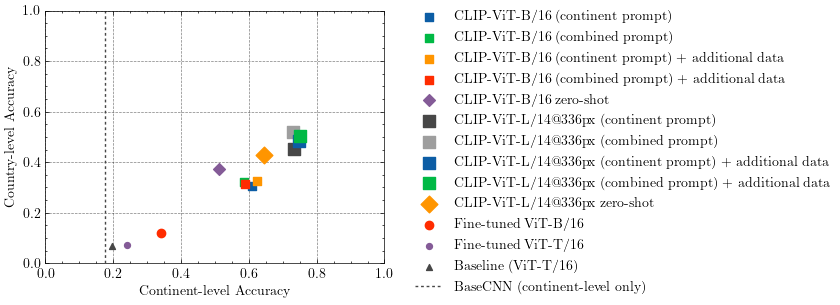

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

import scienceplots

plt.style.use(["science", "std-colors",])
plt.rcParams["axes.axisbelow"] = True
plt.rcParams['figure.figsize'] = (3.5*1.25, 2.625*1.25)

im2gps2k_df = df[df["dataset"] == "im2gps2k"] 
im2gps2k_df = im2gps2k_df[im2gps2k_df["run_name"].str.startswith("CLIP")]

additional_results= {
    "Fine-tuned ViT-B/16": {
        "continent": df.query("run_name == 'ViT-B-16-continent-finetune' & target=='continent' & dataset == 'im2gps2k'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-B-16-country-finetune' & target=='country' & dataset == 'im2gps2k'")["accuracy"].item()
    },
    "Fine-tuned ViT-T/16": {
        "continent": df.query("run_name == 'ViT-T-16-continent-finetune' & target=='continent' & dataset == 'im2gps2k'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-T-16-country-finetune' & target=='country' & dataset == 'im2gps2k'")["accuracy"].item()
    },
    "Baseline (ViT-T/16)": {
        "continent": df.query("run_name == 'ViT-T-16-continent-scratch' & target=='continent' & dataset == 'im2gps2k'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-T-16-country-scratch' & target=='country' & dataset == 'im2gps2k'")["accuracy"].item()
    },
}


continent_accuracy = im2gps2k_df[im2gps2k_df["target"] == "continent"]["accuracy"].values.tolist()
country_accuracy = im2gps2k_df[im2gps2k_df["target"] == "country"]["accuracy"].values.tolist()
run_names = im2gps2k_df[im2gps2k_df["target"] == "continent"]["run_name"].values.tolist()

run_names.extend(additional_results.keys())
continent_accuracy.extend([result["continent"] for result in additional_results.values()])
country_accuracy.extend([result["country"] for result in additional_results.values()])

model_sizes = []
for run in run_names:
    if "ViT-T" in run:
        model_sizes.append("tiny")
    elif "ViT-B" in run:
        model_sizes.append("base")
    elif "ViT-L" in run:
        model_sizes.append("large")
    else:
        model_sizes.append("undefined")

marker_class = []
for run in run_names:
    if "zeroshot" in run:
        marker_class.append("zeroshot")
    elif "CLIP" in run:
        marker_class.append("clip")
    elif "Baseline" in run:
        marker_class.append("scratch")
    elif "ViT" in run:
        marker_class.append("vit-only")
    else:
        model_sizes.append("undefined")

marker_map = {"clip": "s", "zeroshot": "D", "vit-only": "o", "scratch": "^", "undefined": "x"}
# color_map = {"clip": "#0C5DA5", "zeroshot": "#00B945", "vit-only": "#FF9500","scratch": "#FF2C00", "undefined": "red"}

size_map = {
    "tiny": 36/2,
    "base": 36,
    "large": 36*2,
    "undefined": 200
}

run_names = [r.replace("CLIP-ViT-B-16", "CLIP-ViT-B/16").replace("CLIP-ViT-L-14", "CLIP-ViT-L/14").replace("-336", "@336px").replace("-combinedlabels", " (combined prompt)").replace("-continent-zeroshot", " zero-shot").replace("-continent", " (continent prompt)").replace("-osv5m", " + additional data") for r in run_names]


for continent_acc, country_acc, run, size, mclass in zip(continent_accuracy, country_accuracy, run_names, model_sizes, marker_class):
    plt.scatter(continent_acc, country_acc, marker=marker_map[mclass], s=size_map[size], label=f"{run}", alpha=1)


plt.vlines(0.1745, 0, 1, colors='#474747', linestyles=(0, (2,2)), label='BaseCNN (continent-level only)')

plt.legend(loc="upper right", bbox_to_anchor=(2.35, 1.05))
plt.xlabel("Continent-level Accuracy")
plt.ylabel("Country-level Accuracy")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.savefig("figures/im2gps2k-testset-accuracy-overview-plot.png",bbox_inches='tight', dpi=600)
plt.savefig("figures/im2gps2k-testset-accuracy-overview-plot.pdf",bbox_inches='tight', dpi=600)
plt.show()

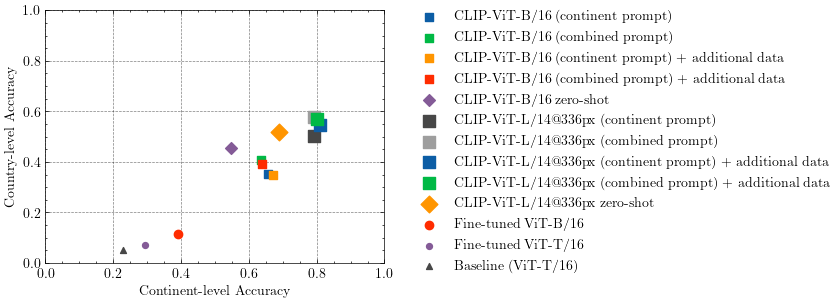

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

import scienceplots

plt.style.use(["science", "std-colors",])
plt.rcParams["axes.axisbelow"] = True
plt.rcParams['figure.figsize'] = (3.5*1.25, 2.625*1.25)

im2gps3k_df = df[df["dataset"] == "im2gps3k"] 
im2gps3k_df = im2gps3k_df[im2gps3k_df["run_name"].str.startswith("CLIP")]

additional_results= {
    "Fine-tuned ViT-B/16": {
        "continent": df.query("run_name == 'ViT-B-16-continent-finetune' & target=='continent' & dataset == 'im2gps3k'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-B-16-country-finetune' & target=='country' & dataset == 'im2gps3k'")["accuracy"].item()
    },
    "Fine-tuned ViT-T/16": {
        "continent": df.query("run_name == 'ViT-T-16-continent-finetune' & target=='continent' & dataset == 'im2gps3k'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-T-16-country-finetune' & target=='country' & dataset == 'im2gps3k'")["accuracy"].item()
    },
    "Baseline (ViT-T/16)": {
        "continent": df.query("run_name == 'ViT-T-16-continent-scratch' & target=='continent' & dataset == 'im2gps3k'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-T-16-country-scratch' & target=='country' & dataset == 'im2gps3k'")["accuracy"].item()
    },
}


continent_accuracy = im2gps3k_df[im2gps3k_df["target"] == "continent"]["accuracy"].values.tolist()
country_accuracy = im2gps3k_df[im2gps3k_df["target"] == "country"]["accuracy"].values.tolist()
run_names = im2gps3k_df[im2gps3k_df["target"] == "continent"]["run_name"].values.tolist()

run_names.extend(additional_results.keys())
continent_accuracy.extend([result["continent"] for result in additional_results.values()])
country_accuracy.extend([result["country"] for result in additional_results.values()])

model_sizes = []
for run in run_names:
    if "ViT-T" in run:
        model_sizes.append("tiny")
    elif "ViT-B" in run:
        model_sizes.append("base")
    elif "ViT-L" in run:
        model_sizes.append("large")
    else:
        model_sizes.append("undefined")

marker_class = []
for run in run_names:
    if "zeroshot" in run:
        marker_class.append("zeroshot")
    elif "CLIP" in run:
        marker_class.append("clip")
    elif "Baseline" in run:
        marker_class.append("scratch")
    elif "ViT" in run:
        marker_class.append("vit-only")
    else:
        model_sizes.append("undefined")

marker_map = {"clip": "s", "zeroshot": "D", "vit-only": "o", "scratch": "^", "undefined": "x"}
# color_map = {"clip": "#0C5DA5", "zeroshot": "#00B945", "vit-only": "#FF9500","scratch": "#FF2C00", "undefined": "red"}

size_map = {
    "tiny": 36/2,
    "base": 36,
    "large": 36*2,
    "undefined": 200
}

run_names = [r.replace("CLIP-ViT-B-16", "CLIP-ViT-B/16").replace("CLIP-ViT-L-14", "CLIP-ViT-L/14").replace("-336", "@336px").replace("-combinedlabels", " (combined prompt)").replace("-continent-zeroshot", " zero-shot").replace("-continent", " (continent prompt)").replace("-osv5m", " + additional data") for r in run_names]


for continent_acc, country_acc, run, size, mclass in zip(continent_accuracy, country_accuracy, run_names, model_sizes, marker_class):
    plt.scatter(continent_acc, country_acc, marker=marker_map[mclass], s=size_map[size], label=f"{run}", alpha=1)


# plt.vlines(0, 0, 1, colors='#474747', linestyles=(0, (1,2)), label='BaseCNN (continent-level only)')

plt.legend(loc="upper right", bbox_to_anchor=(2.35, 1.05))
plt.xlabel("Continent-level Accuracy")
plt.ylabel("Country-level Accuracy")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.savefig("figures/im2gps3k-testset-accuracy-overview-plot.png",bbox_inches='tight', dpi=600)
plt.savefig("figures/im2gps3k-testset-accuracy-overview-plot.pdf",bbox_inches='tight', dpi=600)
plt.show()

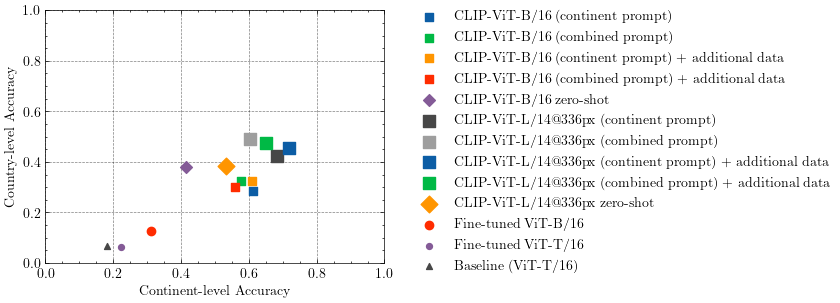

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

import scienceplots

plt.style.use(["science", "std-colors",])
plt.rcParams["axes.axisbelow"] = True
plt.rcParams['figure.figsize'] = (3.5*1.25, 2.625*1.25)

yfcc4k_df = df[df["dataset"] == "yfcc4k"] 
yfcc4k_df = yfcc4k_df[yfcc4k_df["run_name"].str.startswith("CLIP")]

additional_results= {
    "Fine-tuned ViT-B/16": {
        "continent": df.query("run_name == 'ViT-B-16-continent-finetune' & target=='continent' & dataset == 'yfcc4k'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-B-16-country-finetune' & target=='country' & dataset == 'yfcc4k'")["accuracy"].item()
    },
    "Fine-tuned ViT-T/16": {
        "continent": df.query("run_name == 'ViT-T-16-continent-finetune' & target=='continent' & dataset == 'yfcc4k'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-T-16-country-finetune' & target=='country' & dataset == 'yfcc4k'")["accuracy"].item()
    },
    "Baseline (ViT-T/16)": {
        "continent": df.query("run_name == 'ViT-T-16-continent-scratch' & target=='continent' & dataset == 'yfcc4k'")["accuracy"].item(),
        "country": df.query("run_name == 'ViT-T-16-country-scratch' & target=='country' & dataset == 'yfcc4k'")["accuracy"].item()
    },
}


continent_accuracy = yfcc4k_df[yfcc4k_df["target"] == "continent"]["accuracy"].values.tolist()
country_accuracy = yfcc4k_df[yfcc4k_df["target"] == "country"]["accuracy"].values.tolist()
run_names = yfcc4k_df[yfcc4k_df["target"] == "continent"]["run_name"].values.tolist()

run_names.extend(additional_results.keys())
continent_accuracy.extend([result["continent"] for result in additional_results.values()])
country_accuracy.extend([result["country"] for result in additional_results.values()])

model_sizes = []
for run in run_names:
    if "ViT-T" in run:
        model_sizes.append("tiny")
    elif "ViT-B" in run:
        model_sizes.append("base")
    elif "ViT-L" in run:
        model_sizes.append("large")
    else:
        model_sizes.append("undefined")

marker_class = []
for run in run_names:
    if "zeroshot" in run:
        marker_class.append("zeroshot")
    elif "CLIP" in run:
        marker_class.append("clip")
    elif "Baseline" in run:
        marker_class.append("scratch")
    elif "ViT" in run:
        marker_class.append("vit-only")
    else:
        model_sizes.append("undefined")

marker_map = {"clip": "s", "zeroshot": "D", "vit-only": "o", "scratch": "^", "undefined": "x"}
# color_map = {"clip": "#0C5DA5", "zeroshot": "#00B945", "vit-only": "#FF9500","scratch": "#FF2C00", "undefined": "red"}

size_map = {
    "tiny": 36/2,
    "base": 36,
    "large": 36*2,
    "undefined": 200
}

run_names = [r.replace("CLIP-ViT-B-16", "CLIP-ViT-B/16").replace("CLIP-ViT-L-14", "CLIP-ViT-L/14").replace("-336", "@336px").replace("-combinedlabels", " (combined prompt)").replace("-continent-zeroshot", " zero-shot").replace("-continent", " (continent prompt)").replace("-osv5m", " + additional data") for r in run_names]


for continent_acc, country_acc, run, size, mclass in zip(continent_accuracy, country_accuracy, run_names, model_sizes, marker_class):
    plt.scatter(continent_acc, country_acc, marker=marker_map[mclass], s=size_map[size], label=f"{run}", alpha=1)


# plt.vlines(0, 0, 1, colors='#474747', linestyles=(0, (1,2)), label='BaseCNN (continent-level only)')

plt.legend(loc="upper right", bbox_to_anchor=(2.35, 1.05))
plt.xlabel("Continent-level Accuracy")
plt.ylabel("Country-level Accuracy")
plt.xlim(0, 1)
plt.ylim(0, 1)
# plt.grid(True)
plt.savefig("figures/yfcc4k-testset-accuracy-overview-plot.png",bbox_inches='tight', dpi=600)
plt.savefig("figures/yfcc4k-testset-accuracy-overview-plot.pdf",bbox_inches='tight', dpi=600)
plt.show()

In [80]:
print(df)

                      run_name   dataset     target  accuracy  f1_score  \
0      CLIP-ViT-B-16-continent      k78k  continent    0.9097  0.909699   
1      CLIP-ViT-B-16-continent      k78k    country    0.5019  0.131520   
2      CLIP-ViT-B-16-continent    im2gps  continent    0.7215  0.633888   
3      CLIP-ViT-B-16-continent    im2gps    country    0.5021  0.348182   
4      CLIP-ViT-B-16-continent  im2gps2k  continent    0.6105  0.501744   
..                         ...       ...        ...       ...       ...   
155  ViT-B-16-country-finetune  im2gps2k    country    0.1205  0.014169   
156  ViT-B-16-country-finetune  im2gps3k  continent    0.0000  0.000000   
157  ViT-B-16-country-finetune  im2gps3k    country    0.1158  0.018169   
158  ViT-B-16-country-finetune    yfcc4k  continent    0.0000  0.000000   
159  ViT-B-16-country-finetune    yfcc4k    country    0.1254  0.014748   

       recall  precision  
0    0.909687   0.910083  
1    0.170293   0.193838  
2    0.686701   0.

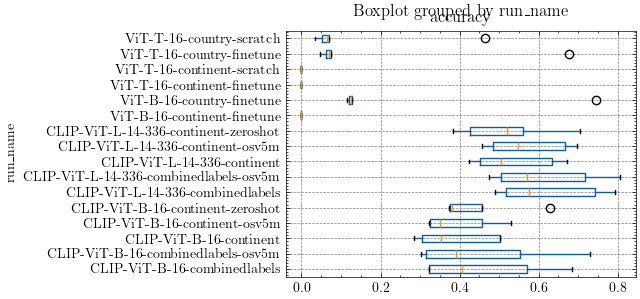

In [81]:
# test1 = df[df["run_name"]=="CLIP-ViT-L-14-336-continent"]
test2 = df[df["target"]=="country"]
test3 = test2.boxplot(column="accuracy", by="run_name", vert=False)

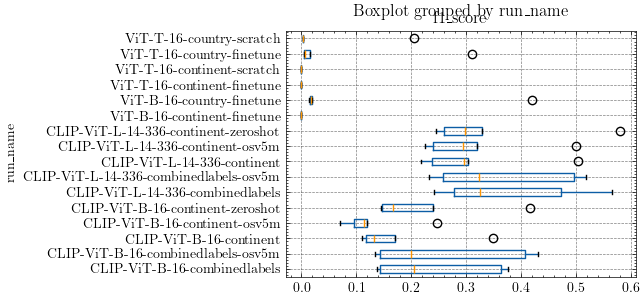

In [82]:
test2 = df[df["target"]=="country"]
test3 = test2.boxplot(column="f1_score", by="run_name", vert=False)

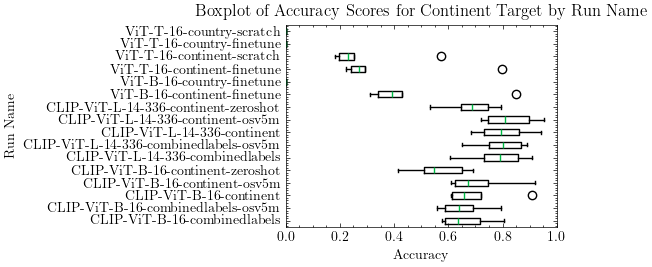

In [83]:

plt.style.use(["science", "std-colors",])
plt.rcParams["axes.axisbelow"] = True
plt.rcParams['figure.figsize'] = (3.5, 2.625)

# Filter the DataFrame to include only 'continent' target
continent_df = df[df['target'] == 'continent']

# Group by 'run_name' and collect accuracy scores
grouped = continent_df.groupby('run_name')['accuracy'].apply(list)


plt.boxplot(grouped, vert=False, patch_artist=False, tick_labels=grouped.index)

# Customize the plot
plt.ylabel('Run Name')
plt.xlabel('Accuracy')
plt.title('Boxplot of Accuracy Scores for Continent Target by Run Name')
plt.xlim(0,1)
# Show the plot
# plt.tight_layout()
plt.grid()
plt.show()

In [84]:
def fix_run_name(name):
    return name.replace("CLIP-ViT-B-16", "CLIP-ViT-B/16").replace("CLIP-ViT-L-14", "CLIP-ViT-L/14").replace("-336", "@336px").replace("-combinedlabels", " (combined prompt)").replace("-continent", " (continent prompt)").replace("-osv5m", " + additional data").replace("-zeroshot", " zero-shot")


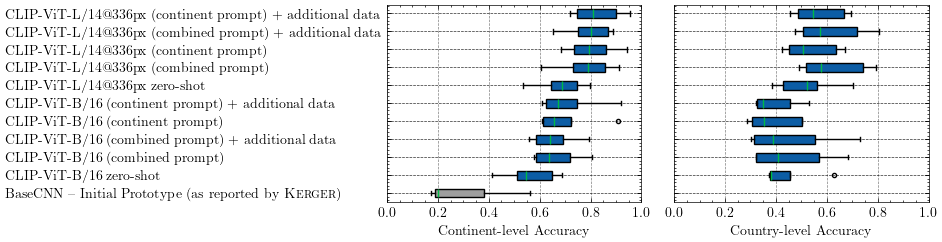

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "std-colors", "grid"])
plt.rcParams['figure.figsize'] = (3.5*2.75, 2.625)

BASECNN_BENCHMARKS = [0.5603, 0.2025, 0.1745]


clip_df = df[df["run_name"].str.startswith("CLIP")]

continent_df = clip_df[clip_df['target'] == 'continent']
country_df = clip_df[clip_df['target'] == 'country']

continent_accuracy_grouped = continent_df.groupby('run_name')['accuracy'].apply(list)
country_accuracy_grouped = country_df.groupby('run_name')['accuracy'].apply(list)

sorted_run_names = continent_accuracy_grouped.apply(np.median).sort_values(ascending=True).index


continent_accuracy_sorted = continent_accuracy_grouped[sorted_run_names]
country_accuracy_sorted = country_accuracy_grouped[sorted_run_names]

sorted_run_names = [r.replace("CLIP-ViT-B-16", "CLIP-ViT-B/16").replace("CLIP-ViT-L-14", "CLIP-ViT-L/14").replace("-336", "@336px").replace("-combinedlabels", " (combined prompt)").replace("-continent-zeroshot", " zero-shot").replace("-continent", " (continent prompt)").replace("-osv5m", " + additional data") for r in sorted_run_names]

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)

continent_accuracy_sorted = pd.concat([pd.Series({'BaseCNN': BASECNN_BENCHMARKS}), continent_accuracy_sorted])
country_accuracy_sorted = pd.concat([pd.Series({'BaseCNN': []}), country_accuracy_sorted])
sorted_run_names.insert(0, r'BaseCNN -- Initial Prototype (as reported by \textsc{Kerger})')

boxp1 = axes[0].boxplot(continent_accuracy_sorted, vert=False, patch_artist=True, tick_labels=sorted_run_names, sym=".")
axes[0].set_xlabel('Continent-level Accuracy')

boxp2 = axes[1].boxplot(country_accuracy_sorted, vert=False, patch_artist=True, tick_labels=["" for _ in sorted_run_names], sym=".")
axes[1].set_xlabel('Country-level Accuracy')


for ax in axes:
    ax.grid(True)
    ax.set_xlim(0,1)
    ax.set_xlim(0,1)

for tick in axes[0].yaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")

axes[0].tick_params(axis='y', pad=275)    

boxp1["boxes"][0].set(facecolor="#9e9e9e")
# boxp1["medians"][0].set(color="#FF2C00")
    

plt.tight_layout()
plt.savefig("figures/clip-model-benchmark-boxplots.png",bbox_inches='tight', dpi=600)
plt.savefig("figures/clip-model-benchmark-boxplots.pdf",bbox_inches='tight', dpi=600)
plt.show()

In [27]:
df

run_name   dataset     target  accuracy  f1_score  \
0      CLIP-ViT-B-16-continent      k78k  continent    0.9097  0.909699   
1      CLIP-ViT-B-16-continent      k78k    country    0.5019  0.131520   
2      CLIP-ViT-B-16-continent    im2gps  continent    0.7215  0.633888   
3      CLIP-ViT-B-16-continent    im2gps    country    0.5021  0.348182   
4      CLIP-ViT-B-16-continent  im2gps2k  continent    0.6105  0.501744   
..                         ...       ...        ...       ...       ...   
155  ViT-B-16-country-finetune  im2gps2k    country    0.1205  0.014169   
156  ViT-B-16-country-finetune  im2gps3k  continent    0.0000  0.000000   
157  ViT-B-16-country-finetune  im2gps3k    country    0.1158  0.018169   
158  ViT-B-16-country-finetune    yfcc4k  continent    0.0000  0.000000   
159  ViT-B-16-country-finetune    yfcc4k    country    0.1254  0.014748   

       recall  precision  
0    0.909687   0.910083  
1    0.170293   0.193838  
2    0.686701   0.615904  
3    0.421770   0.333360  
4    0.524277   0.509824  
..        ...        ...  
155  0.021832   0.017770  
156  0.000000   0.000000  
157  0.027352   0.025227  
158  0.000000   0.000000  
159  0.018892   0.022254  

[160 rows x 7 columns]

In [28]:
best_results = df.groupby(['dataset', 'target']).agg({
    'accuracy': ['max'],
    'f1_score': ['max']
}).reset_index()

best_results

dataset     target accuracy  f1_score
                            max       max
0    im2gps  continent   0.8987  0.850425
1    im2gps    country   0.7426  0.579602
2  im2gps2k  continent   0.7500  0.652118
3  im2gps2k    country   0.5180  0.259342
4  im2gps3k  continent   0.8098  0.693909
5  im2gps3k    country   0.5759  0.328168
6      k78k  continent   0.9536  0.953712
7      k78k    country   0.8051  0.496708
8    yfcc4k  continent   0.7189  0.532509
9    yfcc4k    country   0.4888  0.278068

In [29]:
import numpy as np
np.load("evals/CLIP-ViT-L-14-336-continent-osv5m/k78k-continent.npy").tolist()[3879]

'North America'

In [30]:
print(df.to_string())

                                   run_name   dataset     target  accuracy  f1_score    recall  precision
0                   CLIP-ViT-B-16-continent      k78k  continent    0.9097  0.909699  0.909687   0.910083
1                   CLIP-ViT-B-16-continent      k78k    country    0.5019  0.131520  0.170293   0.193838
2                   CLIP-ViT-B-16-continent    im2gps  continent    0.7215  0.633888  0.686701   0.615904
3                   CLIP-ViT-B-16-continent    im2gps    country    0.5021  0.348182  0.421770   0.333360
4                   CLIP-ViT-B-16-continent  im2gps2k  continent    0.6105  0.501744  0.524277   0.509824
5                   CLIP-ViT-B-16-continent  im2gps2k    country    0.3055  0.117312  0.179646   0.129894
6                   CLIP-ViT-B-16-continent  im2gps3k  continent    0.6563  0.518734  0.593281   0.509743
7                   CLIP-ViT-B-16-continent  im2gps3k    country    0.3530  0.169455  0.265867   0.189492
8                   CLIP-ViT-B-16-continent   

In [31]:
from datasets import load_dataset

ds = load_dataset("jrheiner/geo_training_v3", split="test")

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

In [32]:
ds

Dataset({
    features: ['image', 'image_id', 'longitude', 'latitude', 'country', 'continent', 'source'],
    num_rows: 7020
})

In [33]:
df = ds_im2gps.select_columns(["continent","country","longitude", "latitude"]).to_pandas()

In [34]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Add location to dataframe
df['location'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

gdf = gpd.GeoDataFrame(df, geometry='location')

In [35]:
import fsspec

# https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
with fsspec.open("figures/naturalearth_110m_countries_plot_data.zip") as file:
    gdf2 = gpd.read_file(file)

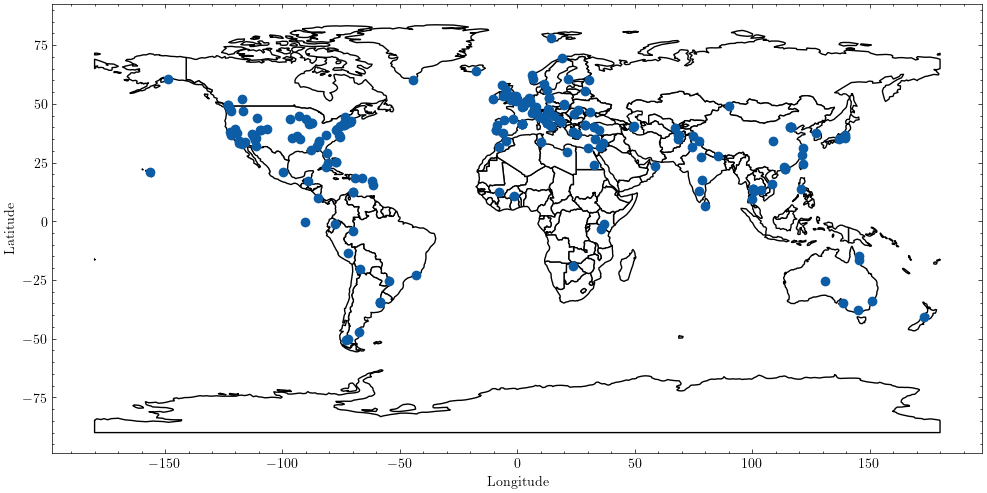

In [36]:
import scienceplots

plt.style.use(["science", "std-colors",])
plt.rcParams["axes.axisbelow"] = True


fig, ax = plt.subplots(figsize=(12, 8))
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
ax.grid()
gdf2.plot(color='white', edgecolor='black', ax=ax)
gdf.plot(ax=ax)
plt.show()

In [37]:
import numpy as np
preds = np.load("evals/CLIP-ViT-L-14-336-continent-osv5m/im2gps-continent.npy")
preds

array(['Africa', 'Africa', 'Africa', 'Africa', 'Africa', 'Africa',
       'Africa', 'South America', 'Africa', 'Africa', 'Africa', 'Asia',
       'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Africa', 'Asia',
       'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia',
       'Asia', 'Asia', 'Asia', 'Oceania', 'Asia', 'Asia', 'Asia', 'Asia',
       'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia',
       'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia',
       'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia',
       'Asia', 'Europe', 'Asia', 'Europe', 'Europe', 'Europe', 'Europe',
       'Europe', 'Europe', 'Europe', 'Europe', 'Asia', 'Europe', 'Europe',
       'Europe', 'Europe', 'South America', 'Europe', 'Europe', 'Europe',
       'Asia', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe',
       'Europe', 'South America', 'Europe', 'Europe', 'Europe', 'Europe',
       'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'E

In [38]:
gts = np.array(ds_im2gps["continent"])
gts

array(['Africa', 'Africa', 'Africa', 'Africa', 'Africa', 'Africa',
       'Africa', 'Africa', 'Africa', 'Africa', 'Africa', 'Asia', 'Asia',
       'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia',
       'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia',
       'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia',
       'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia',
       'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia',
       'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia',
       'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe',
       'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe',
       'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe',
       'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe',
       'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe',
       'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe',
       'Europe', 'Europe', 'Euro

In [39]:
correct_preds = preds == gts
false_preds = preds != gts
correct_preds, false_preds

(array([ True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
      

In [40]:
np.mean(correct_preds/1)

0.8987341772151899

In [41]:
gdf_correct = gdf[correct_preds]
gdf_false = gdf[false_preds]

gdf_correct

continent   country  longitude  latitude                   location
0           Africa     Egypt    29.9461  31.21300     POINT (29.9461 31.213)
1           Africa  Botswana    23.8273 -19.11610   POINT (23.8273 -19.1161)
2           Africa     Egypt    32.8258  24.03270    POINT (32.8258 24.0327)
3           Africa     Ghana    -1.5147  10.84950    POINT (-1.5147 10.8495)
4           Africa     Kenya    36.8154  -1.29300     POINT (36.8154 -1.293)
..             ...       ...        ...       ...                        ...
232  South America   Bolivia   -66.9136 -20.45730  POINT (-66.9136 -20.4573)
233  South America  Colombia   -69.9390  -4.21910    POINT (-69.939 -4.2191)
234  South America   Ecuador   -77.7640  -0.96744   POINT (-77.764 -0.96744)
235  South America      Peru   -71.9989 -13.53650  POINT (-71.9989 -13.5365)
236  South America   Ecuador   -90.2814  -0.39344  POINT (-90.2814 -0.39344)

[213 rows x 5 columns]

In [42]:
gdf_false

continent                 country  longitude  latitude  \
7           Africa                 Morocco    -7.6355   31.3982   
18            Asia             Afghanistan    68.5767   36.8840   
31            Asia                  Cyprus    32.8666   34.9379   
62          Europe                 Belarus    28.7910   55.4858   
71          Europe                   Aruba   -70.0560   12.6070   
76          Europe                   Aruba   -70.0514   12.5322   
80          Europe  Bosnia and Herzegovina    17.7120   43.0654   
88          Europe                 Iceland   -17.7209   63.7946   
105         Europe                  Norway    14.2390   78.0529   
115         Europe                  Poland    19.9347   49.5971   
124         Europe                  Russia    30.3122   59.9405   
132         Europe                 Ukraine    30.7657   46.4757   
149  North America           United States  -148.8120   60.7737   
155  North America                  Belize   -89.0658   17.1293   
163  North America                 Bahamas   -77.3278   25.0735   
166  North America     Antigua and Barbuda   -61.7559   16.9986   
174  North America                  Canada  -117.2397   52.2026   
177  North America           United States  -106.4706   39.4503   
179  North America              Costa Rica   -84.8422    9.9770   
181  North America                Dominica   -61.4554   15.5740   
184  North America               Greenland   -44.2172   60.1852   
205  North America           United States   -75.9785   36.8599   
217        Oceania               Australia   145.5635  -16.6636   
218        Oceania               Australia   145.4485  -14.6667   

                      location  
7      POINT (-7.6355 31.3982)  
18      POINT (68.5767 36.884)  
31     POINT (32.8666 34.9379)  
62      POINT (28.791 55.4858)  
71      POINT (-70.056 12.607)  
76    POINT (-70.0514 12.5322)  
80      POINT (17.712 43.0654)  
88    POINT (-17.7209 63.7946)  
105     POINT (14.239 78.0529)  
115    POINT (19.9347 49.5971)  
124    POINT (30.3122 59.9405)  
132    POINT (30.7657 46.4757)  
149   POINT (-148.812 60.7737)  
155   POINT (-89.0658 17.1293)  
163   POINT (-77.3278 25.0735)  
166   POINT (-61.7559 16.9986)  
174  POINT (-117.2397 52.2026)  
177  POINT (-106.4706 39.4503)  
179     POINT (-84.8422 9.977)  
181    POINT (-61.4554 15.574)  
184   POINT (-44.2172 60.1852)  
205   POINT (-75.9785 36.8599)  
217  POINT (145.5635 -16.6636)  
218  POINT (145.4485 -14.6667)

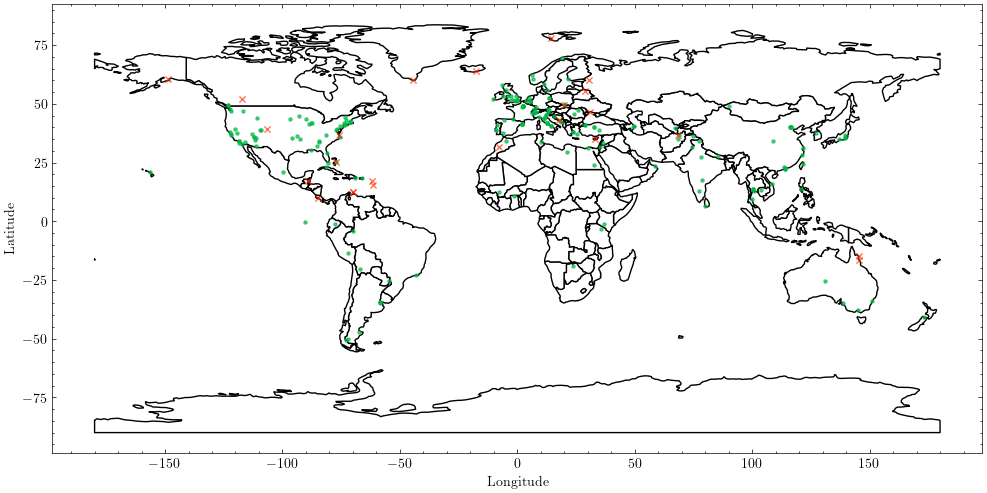

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
ax.grid()
ax.set_axisbelow(True)
gdf2.plot(color='white', edgecolor='black', ax=ax)
gdf_correct.plot(ax=ax, color="#00B945", alpha=0.65, marker=".", markersize=20)
gdf_false.plot(ax=ax, color="#FF2C00", alpha=0.65, marker="x", markersize=20)
plt.show()

In [99]:
import fsspec

with fsspec.open("ne_110m_admin_0_countries.zip") as file:
    gdf2 = gpd.read_file(file)

def plot_eval_preds(np_preds_path, dataset):

    target = "continent" if "continent" in np_preds_path.split("/")[-1] else "country"
    print(target)

    preds = np.load(np_preds_path)

    df = dataset.select_columns(["continent","country","longitude", "latitude"]).to_pandas()
    df['location'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='location')

    gts = np.array(dataset[target])

    correct_preds = preds == gts
    false_preds = preds != gts

    print(np.mean(correct_preds/1))
    print(np.sum(correct_preds/1))

    gdf_correct = gdf[correct_preds]
    gdf_false = gdf[false_preds]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")
    ax.grid(True)
    ax.set_axisbelow(True)
    gdf2.plot(color='white', edgecolor='black', ax=ax)
    gdf_correct.plot(ax=ax, color="#00B945", alpha=0.55, marker="o", markersize=10, label="Correct")
    gdf_false.plot(ax=ax, color="#FF2C00", alpha=0.75, marker="x", markersize=10, label="Wrong")
    plt.legend(frameon=True, title="Predictions", loc="upper right", markerscale=2)
    plt.tight_layout()
    # plt.savefig(f"figures/pred-scatter-plot-{target}-k78k.png",bbox_inches='tight', dpi=600)
    # plt.savefig(f"figures/pred-scatter-plot-{target}-k78k.pdf",bbox_inches='tight', dpi=600)
    plt.show()

In [45]:
from datasets import load_dataset

ds_k78k = load_dataset("jrheiner/geo_training_v3", split="test")
ds_im2gps = load_dataset("jrheiner/im2gps", split="train")
ds_im2gps2k = load_dataset("jrheiner/im2gps2k", split="train")
ds_im2gps3k = load_dataset("jrheiner/im2gps3k", split="train")
ds_yfcc4k = load_dataset("jrheiner/yfcc4k", split="train")


def map_id2label(example):
    example["country_str"] = ds_im2gps.features["country"].int2str(example["country"])
    example["continent_str"] = ds_im2gps.features["continent"].int2str(example["continent"])
    return example

ds_im2gps = ds_im2gps.map(map_id2label, batched=True)
ds_im2gps = ds_im2gps.remove_columns(["country", "continent"])
ds_im2gps = ds_im2gps.rename_column("country_str", "country")
ds_im2gps = ds_im2gps.rename_column("continent_str", "continent")

def map_id2label(example):
    example["country_str"] = ds_im2gps2k.features["country"].int2str(example["country"])
    example["continent_str"] = ds_im2gps2k.features["continent"].int2str(example["continent"])
    return example

ds_im2gps2k = ds_im2gps2k.map(map_id2label, batched=True)
ds_im2gps2k = ds_im2gps2k.remove_columns(["country", "continent"])
ds_im2gps2k = ds_im2gps2k.rename_column("country_str", "country")
ds_im2gps2k = ds_im2gps2k.rename_column("continent_str", "continent")


Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

continent
0.9535612535612535
6694.0


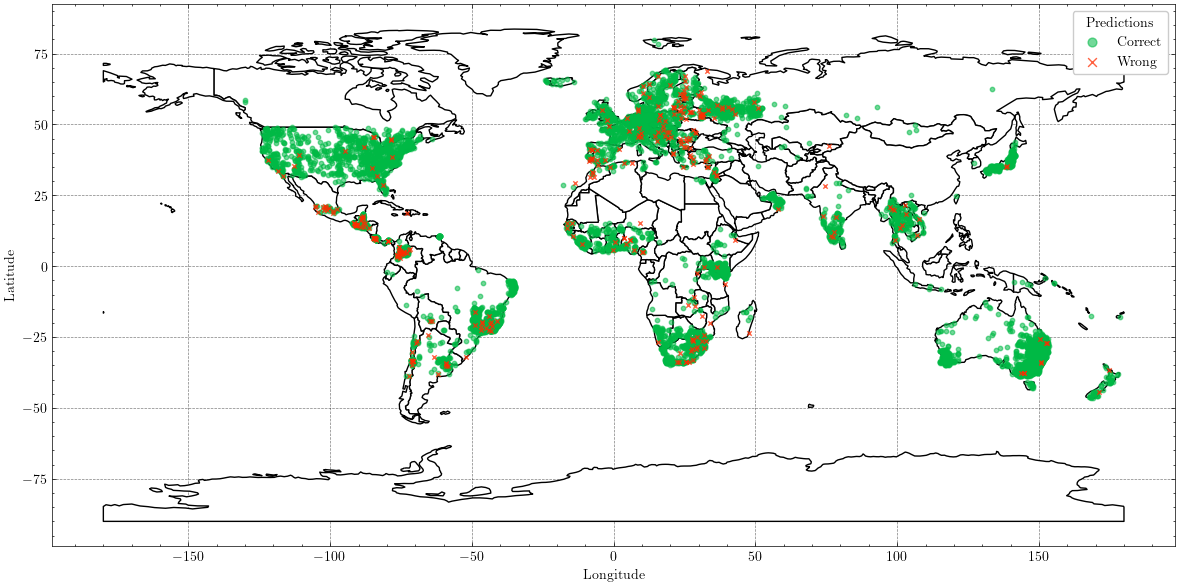

In [98]:
plot_eval_preds("evals/CLIP-ViT-L-14-336-continent-osv5m/k78k-continent.npy", ds_k78k)

In [47]:
# plot_eval_preds("evals/CLIP-ViT-L-14-336-continent-osv5m/im2gps3k-continent.npy", ds_im2gps3k)

In [94]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (3.5*1.45, 2.625*1.45)

def get_report_and_cfs_matrix(np_preds_path, dataset):
    target = "continent" if "continent" in np_preds_path.split("/")[-1] else "country"
    print(target)
    preds = np.load(np_preds_path).tolist()
    gts = np.array(dataset[target]).tolist()
    print(preds)
    print(gts)

    print(classification_report(gts, preds))
    print("-"*60)
    start_color = "white"
    end_color = "#0C5DA5"  
    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("custom_cmap", [start_color, end_color])
    ConfusionMatrixDisplay.from_predictions(gts, preds, xticks_rotation="vertical", cmap=cmap, colorbar=False)
    plt.tight_layout()
    plt.grid(False)
    # plt.tick_params(which="both", length=0)
    # plt.savefig(f"figures/pred-confusion-matrix-{target}.png",bbox_inches='tight', dpi=600)
    # plt.savefig(f"figures/pred-confusion-matrix-{target}.pdf",bbox_inches='tight', dpi=600)
    plt.show()

continent
['North America', 'South America', 'Asia', 'Oceania', 'South America', 'Africa', 'Oceania', 'North America', 'South America', 'South America', 'South America', 'Europe', 'South America', 'Oceania', 'North America', 'Europe', 'Asia', 'Oceania', 'South America', 'Asia', 'South America', 'North America', 'North America', 'South America', 'Asia', 'Europe', 'Oceania', 'Oceania', 'Europe', 'Asia', 'Asia', 'Asia', 'South America', 'Asia', 'Africa', 'Africa', 'Oceania', 'North America', 'North America', 'Oceania', 'Europe', 'South America', 'South America', 'North America', 'North America', 'Africa', 'Asia', 'North America', 'Asia', 'Africa', 'South America', 'North America', 'South America', 'South America', 'Asia', 'North America', 'Asia', 'South America', 'South America', 'South America', 'Oceania', 'Asia', 'Africa', 'South America', 'Oceania', 'Asia', 'Africa', 'Asia', 'Africa', 'Oceania', 'North America', 'Europe', 'North America', 'Africa', 'North America', 'South America', 'As

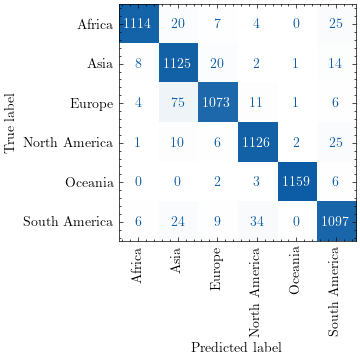

In [95]:
get_report_and_cfs_matrix("evals/CLIP-ViT-L-14-336-continent-osv5m/k78k-continent.npy", ds_k78k)

continent
['North America', 'North America', 'Asia', 'Asia', 'Europe', 'Asia', 'North America', 'Europe', 'South America', 'South America', 'North America', 'South America', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'North America', 'North America', 'North America', 'North America', 'North America', 'North America', 'Europe', 'Europe', 'Europe', 'Oceania', 'South America', 'Oceania', 'Oceania', 'South America', 'Oceania', 'Oceania', 'Oceania', 'Oceania', 'Asia', 'North America', 'Europe', 'North America', 'North America', 'Europe', 'North America', 'Europe', 'Europe', 'Asia', 'North America', 'Europe', 'Asia', 'Asia', 'North America', 'North America', 'Europe', 'South America', 'Europe', 'North America', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'South America', 'Europe', 'North America', 'Europe', 'Europe', 'Asia', 'Asia', 'Europe', 'Europe', 'North America', 'South America', 'North America', 'Asia', 'South America', 'North America',

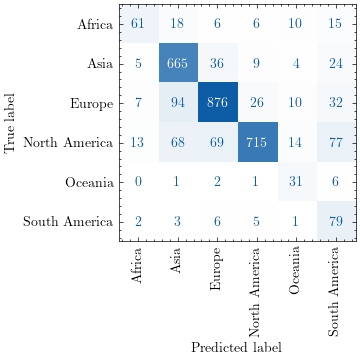

In [96]:
get_report_and_cfs_matrix("evals/CLIP-ViT-L-14-336-continent-osv5m/im2gps3k-continent.npy", ds_im2gps3k)

In [51]:
preds = np.load("evals/CLIP-ViT-L-14-336-continent-osv5m/im2gps3k-continent.npy").tolist()
gts = np.array(ds_im2gps3k["continent"]).tolist()

In [52]:
wrong_pred_idx = []

for i, p in enumerate(preds):
    if p != gts[i]:
        wrong_pred_idx.append(i)

In [53]:
idx = np.random.choice(wrong_pred_idx)
print(idx)

219


Europe North America


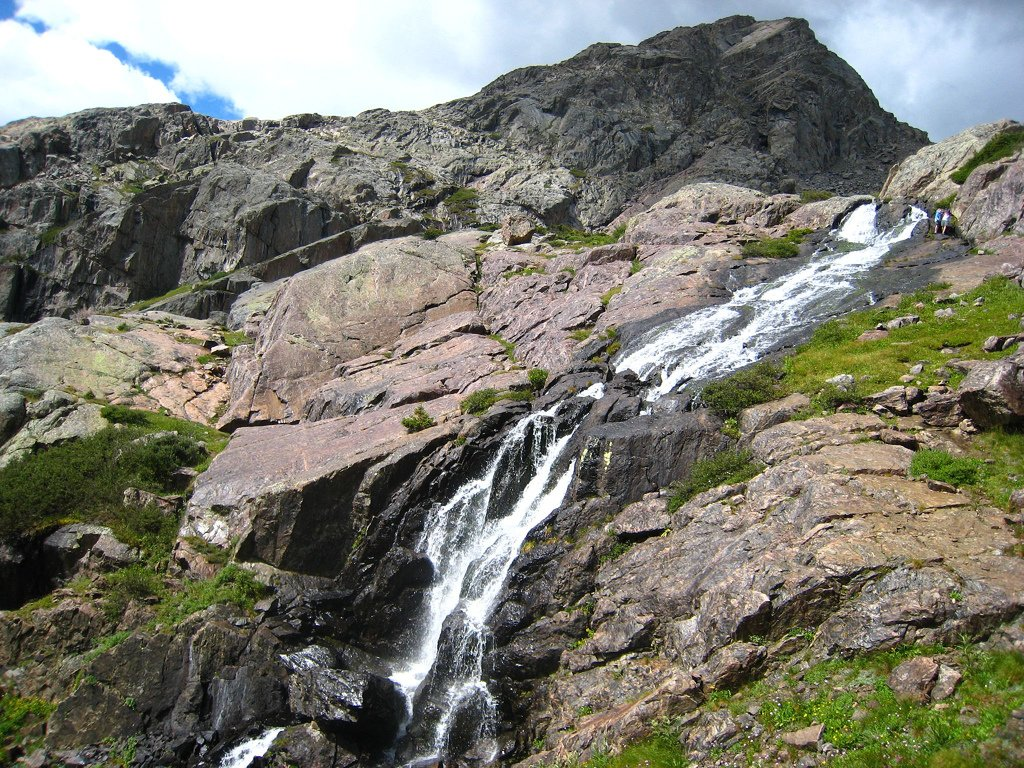

In [54]:
print(preds[idx], gts[idx])
ds_im2gps3k[int(idx)]["image"]

In [55]:
from transformers.image_transforms import resize

def show_and_save_ds_image(idx):
    im = resize(np.array(ds_im2gps3k[int(idx)]["image"]), (336, 336))
    plt.axis("off")
    plt.imshow(im)
    plt.savefig(f"figures/{idx}_pred-{preds[idx]}_gts-{ds_im2gps3k[int(idx)]['continent']}.png",bbox_inches='tight', dpi=300)
    plt.savefig(f"figures/{idx}_pred-{preds[idx]}_gts-{ds_im2gps3k[int(idx)]['continent']}.pdf",bbox_inches='tight', dpi=300)
    ds_im2gps3k[int(idx)]

2024-08-18 10:28:35.086118: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-18 10:28:35.228658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 10:28:35.282111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 10:28:35.297696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-18 10:28:35.399149: I tensorflow/core/platform/cpu_feature_guar

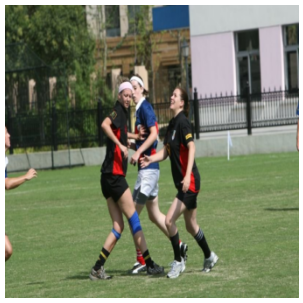

In [56]:
for i in [70,58,2996,648,2417,219,2152,2595,1197]:
    show_and_save_ds_image(i)